## Project 2 Proposal
I want to use the daily data for the US Stock Markets that are found at this site: 

https://stooq.com/db/h/  

The site provides a single text file for all active stocks and exchange traded funds (ETFs) currently traded on the NYSE and NASDAQ exchanges.  The question that I want to answer is:
Was Steve Bigalow right about his “Best Friend Signal?”
For background, Steve Bigalow was a candle stick trader who talked about patterns that indicated swings in price were coming.  What he called the “Best Friend Signal” was a doji (a day of trading where the open and close price are equal or close to equal) followed by a “gap up” (where the open of the day higher than either the open or close of the previous day) and a close above the 8 day exponential moving average (EMA).  He stated that when these 3 things occurred, the stock price was “very likely” to go up.  I would like to test this.  
I plan on limiting the analysis in the following ways:
1.	I will only be looking at stocks in the S&P 500
2.	I will only be looking at the last 2 years of data
3.	I will only be looking at signals that occur over the time of 2 days.  In other words, I will look at events where the price is below the 8 day EMA, a doji occurs, and the next day the stock gaps up and closes above the 8 day EMA.

I will measure the high of the stock over the following 10 days of trading and analyze the highest price during that time as a percentage of the price at the end of the signal.  I will produce a table of signal events and the highest price in the next 10 days.  From that table I will determine if Steve Bigalow was right or if there is anything better than chance (a coin flip in this case) to the signal.

## Instructions for the Reviewer:
You will need to download the data for this project.  You can find it here:

https://drive.google.com/file/d/15N_zFtOXr7lx_MGlyV6ywADFHLmXe9Jx/view?usp=sharing

This will unzip to a directory called Project 2 that will contain a .dat file containing the ticker symbols for the S&P 500 and the stock downloads with data up to November 19th of this year.  You are welcome to download all the data and run this with more recent data.  Click the Stooq link above and click the link for the US Daily ASCII stocks.  When you unzip that file you will have to copy all the Stock files into this data directory.  Don't worry about the ETF files.

Text me at 443-745-7469 or email me at wj53138@umbc.edu if you have any questions.  It is probably best to text me even if you do send me an email.  Just let me know that I need the check my email.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

Each of the following python blocks has a print statement at the end.  You can uncomment it to see what is going on.

In [2]:
#First, let's read in the list of S&P 500 Symbols
sp500symbols = []
with open(r'.\sp500symbols.dat', 'r') as fh:
    for line in fh:
        sp500symbols.append(format(line.strip()))
#print(sp500symbols)

In the next block we are going to use an Exponential Moving Average (EMA).  This is a type of average that is used in stock analysis.  Here is some background information on the EMA.

[Exponential Moving Average](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema#:~:text=Exponential%20Moving%20Average%20(EMA)%20is,data%20that%20is%20more%20current.)

We will be using the 8 Day EMA.


In [3]:
#Now we will build a dictionary of dataframes that contain the data that we will analyze.
stockDataFrames = {}
#TODO make this for all files
for symbol in sp500symbols:
    datFileName =  '.\\data\\' + f'{symbol}.us.txt'
    if not os.path.exists(datFileName):
        print(f'File {datFileName} does not exist, skipping')
        continue
    df = pd.read_csv(datFileName)
    #first let's rename the columns so they are easier to use.
    for key in df.keys():    
        df.rename(columns={key: key[1:-1]}, inplace=True)
    #next, let's get those dates properly formatted.
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y%m%d')
    #Then we calculate the EMA 8 for the symbol.
    df['EMA8'] = round(df['CLOSE'].ewm(span=8, adjust=False).mean(), 2)
    ## IF WE NEED TO ADD STOCHASTIC WE WILL DO IT HERE!
    #We are only looking at data for the last 2 years (or so), so this data frame does not need to carry all the data since 1970.  
    # Thus, We will only keep the last 510 trading days. (there ar 252 trading days in a year so this will be a little more than 2 years of data)  
    #if len(df.index) < 510:
    #    print(f'Skipping {symbol} because it does not have enough rows (it has {len(df.index)})')
    #    continue
    df = df.iloc[-510:]
    df.reset_index(drop=True, inplace=True)
    stockDataFrames[symbol] = df
#stockDataFrames['MMM'].tail(10)

Now I have a list of data frames containing the last 2 years of daily information from each stock in the S&P 500.  Now it is time to go through each symbol and see if Steve Bigalow's prediction was correct for these symbols.  
First, I am going to define what makes a doji (a day when the stock opens and closes at about the same price).  
Second, I am going to define a gap-up event as an when the stock opens the next day higher than the open and close of the previous day by a defined percentage.

Then I am going to make a data frame for the events I want to test.  I will add an event to the data frame if there is a doji fully below the EMA8 followed by a gap-up that closes above the EMA8. 

In [4]:
dojiPercentage = .003 #A candle stick is a doji if the open and close are withing this percentage of each other.  .003 seems to be a good cutoff.
gapPercentage = .005 # A gap-up will be measured by the stock opening at 1.(x) of the higher of the previous days open or close
#Now I will define a list that will hold our testable events (a Doji followed by a gap-up that closes above the EMA8).
#We will turn this into a data frame once it is built
testEvents = pd.DataFrame(columns=['TICKER', 'DATE'])
#testEventsList.append(['TICKER', 'DATE'])
#Now let's loop over the data frames in the list
for df in stockDataFrames.values():
    #then loop over each record looking for dojis
    for row in df.itertuples():
        #first, let's see if the whole candle is below the EMA8
        if row.OPEN < row.EMA8 and row.CLOSE < row.EMA8:
            #now let's see if the candle is a doji
            dojiHigh =  row.OPEN *   (1 + dojiPercentage)
            dojiLow =   row.OPEN *   (1 - dojiPercentage)
            if dojiLow <= row.CLOSE <= dojiHigh:
                #Now we need to check to see if we are at the last row of data in this data frame. 
                # If so, we should not try to look at data that does not exist.
                if row.Index >= (len(df.index) -1):
                    continue
                #Now let's find out if the next day is a gap-up
                #First we will set the floor of the gap-up.  The gap floor will be measured from the higher of the open and close of the doji
                gapFloor = row.CLOSE * (1 + gapPercentage)
                if row.OPEN > row.CLOSE:
                    gapFloor = row.OPEN * (1 + gapPercentage) 
                #Lets get the next day into a row
                nextDay = df.iloc[row.Index+1]
                #If the stock gaps up (open and close are above the gap floor) AND the close is above the EMA8
                if nextDay['OPEN'] > gapFloor and nextDay['CLOSE'] > gapFloor and nextDay['CLOSE'] > nextDay['EMA8']:
                    #Then we check to see if there are 11 days of data we can test after the event.
                    if row.Index <= (len(df.index) - 11):
                        testEvents.loc[len(testEvents)] = [row.TICKER[:-3], row.DATE]
                    #This else statement provides feedback on what was not saved to the test cases. You can uncomment it to get some insight.
                    #else:
                    #    print(f'{row.TICKER[:-3]} {row.DATE} does not have enough data to analyze')
                    #Below is some debug code I wrote to make sure that I was doing the cut-off correctly
                    #if row.Index == 498:
                    #    print('DINGDINGDING')
                    #    print(f'{row.TICKER[:-3]} {row.DATE}')
#testEvents.tail(25)

Now we have our data frame of testable events.  Each row of this data frame is just a ticker symbol and a date.  Since our full data set is stored in a dictionary (and the keys are ticker symbols) we can now access each data frame in the dictionary by the ticker symbol key in the Test Event data frame.  

The questions that I am trying to answer are:
1. After an event, is there an opportunity to sell the stock at a gain in the next 10 days?  To answer this question we will look at just the highs of the next 10 days.
2. What is the percentage gain per event where the stock is higher within 10 days of the event?
3. How many days after the event (within 10 days) did the high occur? 
4. What percentage of events result in an opportunity to sell at a higher price?
5. For events where there is not an opportunity to sell at a higher price in the next 10 days, what is the worst case for selling during said time frame?  For this we will be looking at just the lows for the next 10 days.

Thus this project will be looking at 12 days of data per event.  The doji day, the gap up day, and the subsequent 10 days.  We will assume that we can buy the stock at the close price of the gap up day.

In [5]:
# First, lets build some dataframes to hold wins and losses
wins =   pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', '10DAY_HIGH', 'PERCENT_GAIN', 'DAY_OF_HIGH'])
losses = pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', '10DAY_LOW',  'PERCENT_LOSS'])
# Just for fun, let's see what the state is at the end (CLOSE) of the 10 day period
allEvents = pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', 'OUT_PRICE',  'PERCENT_CHANGE'])
#Now, let's loop over the test results:
for testEvent in testEvents.itertuples():
    #This next line of code gets the index of the start of the 12 day span from the dataframe of the ticker in the dictionary of data frames.
    eventStartIndex = stockDataFrames[testEvent.TICKER].index[stockDataFrames[testEvent.TICKER]['DATE'] == testEvent.DATE][0]
    #Now I will create a new data frame of the 12 rows I want to test because I don't want to keep referencing the data as I did in that last line.
    df = stockDataFrames[testEvent.TICKER].iloc[eventStartIndex:(eventStartIndex + 12)]
    #if 10 days since the event have not elapsed, we can't have good analysis so skip this event.
    if len(df) < 12:
        continue
    #Now I will reindex the dataframe in place so I can easily access the days by index
    df.reset_index(drop=True, inplace=True)
    #For the purpose of this project, We will assume that we can purchase the stock at the close price of the second day (index 1).  
    #We will then measure the best case scenario of the gain over the next 10 days.  If there is no gain over the next 10 days, we will measure the worse case 
    #scenario over the next 10 days.  We will also calculate a percentage gain/loss of each event.  If the event is a gain, we will add the event to a the wins
    #dataframe.  If it is a loss, we will add it to the losses dataframe.
    purchasePrice = df['CLOSE'][1]
    tenDayHigh = df['HIGH'].iloc[2:].max()
    #If we have a "winner"
    if tenDayHigh > purchasePrice:
        #Calculate the highest percentage Gained
        percentGain = (tenDayHigh/purchasePrice) - 1
        #How many days after purchase does the high occur? (we purchase at CLOSE at index 1 so take away 1)
        highPriceIndex = df.iloc[2:].index[df['HIGH'].iloc[2:] == tenDayHigh][0] - 1
        #add it to the winners dataframe
        wins.loc[len(wins)] = [testEvent.TICKER, testEvent.DATE, purchasePrice, tenDayHigh, percentGain, highPriceIndex]
    #if we have a loser (we will put ties in the loss category)
    if tenDayHigh <= purchasePrice:
        #find the worst case
        tenDayLow  = df['LOW'].iloc[2:].min()
        #calculate the loss percentage
        percentLoss = (purchasePrice/tenDayLow) - 1
        #add it to the losses dataframe
        losses.loc[len(losses)] = [testEvent.TICKER, testEvent.DATE, purchasePrice, tenDayLow, percentLoss]
    #add the event to the all events dataframe
    allEvents.loc[len(allEvents)] = [testEvent.TICKER, testEvent.DATE, purchasePrice, df['CLOSE'][11], (df['CLOSE'][11]/purchasePrice) - 1 ]
#print(wins.tail(15))
#print(losses.tail(15))
#print(allEvents.tail(15))

Now it is time to do some analysis on the data we have collected.  Let's look at what we have built.  We have 3 data frames:
1. Wins has best case scenario of an improvement of price that occurs after a signal event.
2. Losses which has the worse case scenario over the next 10 days after a signal
3. All the signals followed by the result of holding the stock for 10 days.  

Now we can do some analysis on the data

In [6]:
allCount = len(allEvents)
winCount = len(wins)
lossCount = len(losses)

print(f'There were {allCount} signals with 10 days of data that we could analyze.  Of those {allCount}, {winCount} had the oppotunity for gains and {lossCount} would have resulted in some loss.')
print(f'{winCount} + {lossCount} = {winCount + lossCount} which should be the number of events in "allEvents"({allCount}).\n')
print(f'{round((winCount/allCount)*(100),2)}% Were wins with an average maximum possible gain of {round(wins['PERCENT_GAIN'].mean() * 100, 2)}%.')
print(f'{round((lossCount/allCount)*(100),2)}% Were wins with an average maximum possible loss of {round(losses['PERCENT_LOSS'].mean() * 100, 2)}%.\n')
print(f'The average result of buying at the close of the gap up and holding for 10 days is {round(allEvents['PERCENT_CHANGE'].mean() * 100, 2)}%.')

#wins =   pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', '10DAY_HIGH', 'PERCENT_GAIN', 'DAY_OF_HIGH'])
#losses = pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', '10DAY_LOW',  'PERCENT_LOSS'])
#allEvents = pd.DataFrame(columns=['TICKER', 'DATE', 'IN_PRICE', 'OUT_PRICE',  'PERCENT_CHANGE'])

There were 1503 signals with 10 days of data that we could analyze.  Of those 1503, 1447 had the oppotunity for gains and 56 would have resulted in some loss.
1447 + 56 = 1503 which should be the number of events in "allEvents"(1503).

96.27% Were wins with an average maximum possible gain of 4.9%.
3.73% Were wins with an average maximum possible loss of 10.68%.

The average result of buying at the close of the gap up and holding for 10 days is 0.82%.


When, in the 10 days after a signal does the high occur?

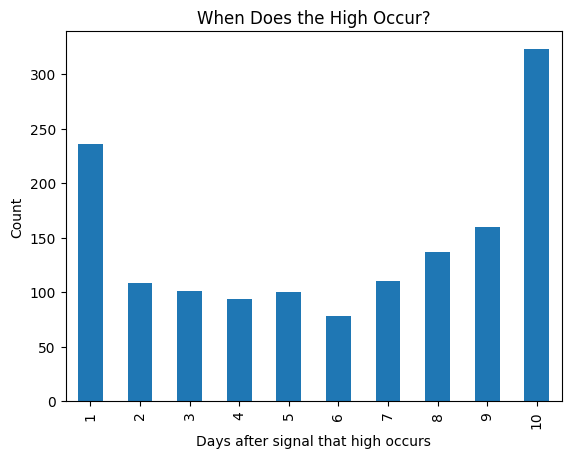

In [13]:
highDayCounts = wins['DAY_OF_HIGH'].value_counts().sort_index()
highDayCounts.plot(kind='bar')
plt.xlabel("Days after signal that high occurs")
plt.ylabel("Count")
plt.title("When Does the High Occur?")
plt.show()

Okay, that is interesting.  What is the average high (in percentage) for each day assuming the high occurs on that day?

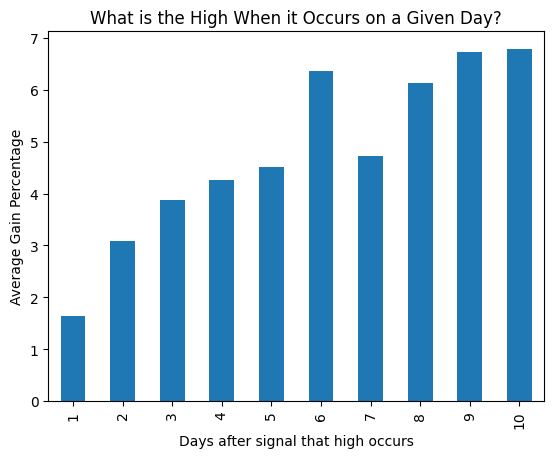

In [22]:
avgPercentGainByDay = wins.groupby('DAY_OF_HIGH')['PERCENT_GAIN'].mean() * 100
avgPercentGainByDay.plot(kind='bar')
plt.xlabel("Days after signal that high occurs")
plt.ylabel("Average Gain Percentage")
plt.title("What is the High When it Occurs on a Given Day?")
plt.show()

## Conculsion
I thought that this analysis would show that Steve Bigalow was wrong about his "Best Friend Signal"  I can not make that conclusion from this analysis and there seems to be good date pointing to him having been correct.  I would like to develop a strategy based on the findings here and run simulations on the existing data to see if the strategy would be successful.